# Survey for additional EFT effects

The purpose is to find whether we have additional EFT effects that are not affecting LT.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from yahist import Hist1D

import awkward as ak

#f_in    = '/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoLep_aTtoHad_5f_EFT_NLO_RunIISummer20_NanoGEN_NANO_v13/output_100.root'
f_in = 'excl_topW.root'
# load a subset of events
n_max = 5000
events = NanoEventsFactory.from_root(
    f_in,
    schemaclass = NanoAODSchema,
    #entry_stop = n_max,
).events()



## Inspecting NanoGEN collections

In [3]:
events.fields

['LHEPart',
 'GenVtx',
 'GenPart',
 'GenMET',
 'GenDressedLepton',
 'GenIsolatedPhoton',
 'GenJetAK8',
 'run',
 'Generator',
 'MET',
 'genWeight',
 'event',
 'LHEWeight',
 'LHEReweightingWeight',
 'LHEPdfWeight',
 'GenJet',
 'LHE',
 'GenVisTau',
 'PSWeight',
 'luminosityBlock',
 'LHEScaleWeight',
 'HTXS']

In [4]:
events.LHEWeight.fields

['originalXWGTUP',
 'cpt_0p_cpqm_0p_nlo',
 'cpt_3p_cpqm_0p_nlo',
 'cpt_6p_cpqm_0p_nlo',
 'cpt_0p_cpqm_3p_nlo',
 'cpt_0p_cpqm_6p_nlo',
 'cpt_3p_cpqm_3p_nlo']

In [5]:
ak.num(events.GenDressedLepton, axis=1)

<Array [2, 2, 2, 2, 1, 1, ... 1, 0, 0, 1, 2, 1] type='110000 * int64'>

Problem with dressed leptons is that those are just electrons and muons.
In order to check if the samples actually make sense we therefore check if the samples do just have two leptons, e/mu/tau.

In [6]:
gp = events.GenPart

In [7]:
GenLep_all = gp[(((abs(gp.pdgId)==11)|(abs(gp.pdgId)==13)|(abs(gp.pdgId)==15)) & ((gp.statusFlags & (1 << 13)) > 0) & ((gp.statusFlags & 1) > 0) )]
ak.num(GenLep_all, axis=1)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='110000 * int64'>

Looks fine!
Then we only select generated electrons and muons with our fiducial cuts.

In [8]:
gen_lep = gp[(
    ((abs(gp.pdgId)==11)|(abs(gp.pdgId)==13)) &\
    ((gp.statusFlags & (1 << 13)) > 0) &\
    ((gp.statusFlags & 1) > 0) &\
    (gp.pt>20) & (abs(gp.eta)<2.5)
)]
ak.num(gen_lep, axis=1)

<Array [1, 1, 2, 2, 1, 1, ... 1, 0, 0, 0, 2, 0] type='110000 * int64'>

Also apply some cuts on jets.

In [9]:
gen_jet = events.GenJet[(
    (events.GenJet.pt>30) &\
    (abs(events.GenJet.eta)<2.4)
)]

And a very basic events selection -> two electrons and muons, at least 3 jets.

In [10]:
from Tools.helpers import pad_and_flatten, mt, fill_multiple, zip_run_lumi_event, get_four_vec_fromPtEtaPhiM, get_samples

ev = events[ak.num(gen_lep, axis=1)==2]

lep = gen_lep[ak.num(gen_lep, axis=1)==2]
#lep['p4'] = get_four_vec_fromPtEtaPhiM(lep, lep.pt, lep.eta, lep.phi, lep.mass, copy=False)

jet = gen_jet[ak.num(gen_lep, axis=1)==2]
jet = jet[(jet.delta_r(lep[:,0])>0.4) & (jet.delta_r(lep[:,1])>0.4)]
#jet['p4'] = get_four_vec_fromPtEtaPhiM(jet, jet.pt, jet.eta, jet.phi, jet.mass, copy=False)

ev = ev[ak.num(jet)>2]
lep = lep[ak.num(jet)>2]
jet = jet[ak.num(jet)>2]


## Plotting

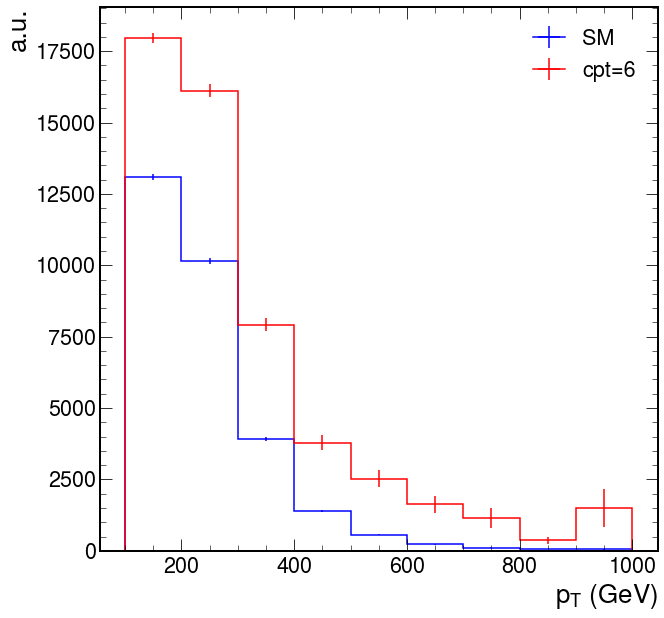

In [11]:
bins = "9,100,1000"

h_lt_SM = Hist1D(ak.sum(lep.pt, axis=1) + ev.GenMET.pt, bins=bins, overflow=True)
h_lt_BSM = Hist1D(ak.sum(lep.pt, axis=1) + ev.GenMET.pt, bins=bins, weights=ev.LHEWeight.cpt_6p_cpqm_0p_nlo, overflow=True)

              
f, ax = plt.subplots()

hep.histplot(
    [h_lt_SM.counts, h_lt_BSM.counts],
    h_lt_SM.edges,
    w2 = [h_lt_SM.errors**2, h_lt_BSM.errors**2],
    histtype="step",
    stack=False,
    label=[r'SM', r'cpt=6'],
    color=['blue', 'red'],
    ax=ax)

#h.plot()

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$p_{T}\ (GeV)$')

plt.legend()

## LT based reweighting

If we apply a reweighting based on LT to events and look at other (independent) observables we can see if there are actually effects that are not captured by LT. We use the yahist lookup functionality to implement the reweighting.


In [12]:
h_lt_SM_norm = h_lt_SM/np.sum(h_lt_SM.counts)
h_lt_BSM_norm = h_lt_BSM/np.sum(h_lt_BSM.counts)
h_reweight = h_lt_BSM_norm/h_lt_SM_norm

In [13]:
h_reweight.lookup(150)

0.7662326090533824

In [14]:
bins = "9,100,1000"

lt = ak.sum(lep.pt, axis=1) + ev.GenMET.pt

h_lt_BSM_reweighted = Hist1D(lt, bins=bins, weights=h_reweight.lookup(lt), overflow=True)
h_lt_BSM_reweighted_norm = h_lt_BSM_reweighted/np.sum(h_lt_BSM_reweighted.counts)

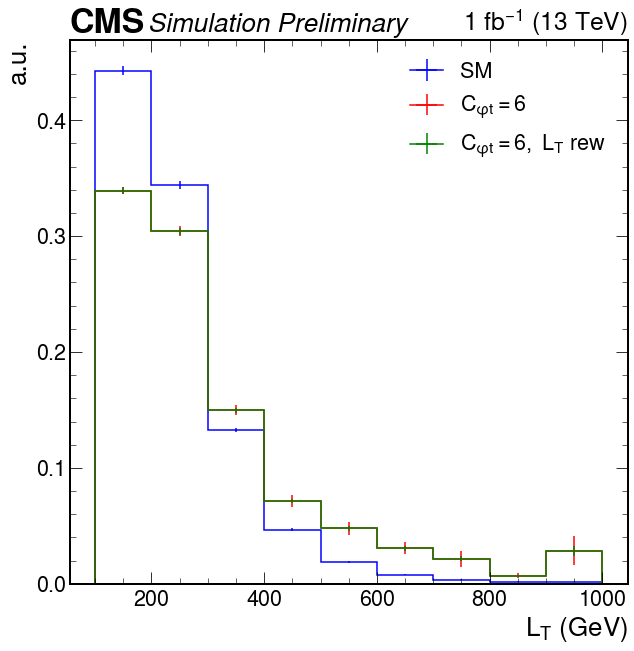

In [29]:
f, ax = plt.subplots()

hep.cms.label(
        "Preliminary",
        data=False,
        lumi=1,
        loc=0,
        ax=ax,
    )

hep.histplot(
    [h_lt_SM_norm.counts, h_lt_BSM_norm.counts, h_lt_BSM_reweighted_norm.counts],
    h_lt_SM_norm.edges,
    yerr = [h_lt_SM_norm.errors, h_lt_BSM_norm.errors, h_lt_BSM_reweighted_norm.errors],
    histtype="step",
    stack=False,
    label=[r'SM', r'$C_{\varphi t}=6$', r'$C_{\varphi t}=6,\ L_{T}$ rew'],
    color=['blue', 'red', 'green'],
    ax=ax)

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$L_{T}\ (GeV)$')

plt.legend()

f.savefig('./closure.pdf')

Great, the sanity closure works. Let's do the survey more systematically.

In [26]:
def get_plot(var, binning, axis_label=r'$p_{T}\ (GeV)$', log=True, save='./plot.pdf'):

    
    
    h_SM = Hist1D(var, bins=binning, overflow=True)
    h_BSM = Hist1D(var, bins=h_SM.edges, weights=ev.LHEWeight.cpt_6p_cpqm_0p_nlo, overflow=True)
    h_BSM_rew = Hist1D(var, bins=h_SM.edges, weights=h_reweight.lookup(lt), overflow=True)

    h_SM_norm = h_SM/np.sum(h_SM.counts)
    h_BSM_norm = h_BSM/np.sum(h_BSM.counts)
    h_BSM_rew_norm = h_BSM_rew/np.sum(h_BSM_rew.counts)

    f, ax = plt.subplots()

    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=1,
        loc=0,
        ax=ax,
    )
    
    hep.histplot(
        [h_SM_norm.counts, h_BSM_norm.counts, h_BSM_rew_norm.counts],
        h_SM_norm.edges,
        yerr = [h_SM_norm.errors, h_BSM_norm.errors, h_BSM_rew_norm.errors],
        histtype="step",
        stack=False,
        label=[r'SM', r'$C_{\varphi t}=6$', r'$C_{\varphi t}=6,\ L_{T}$ rew'],
        color=['blue', 'red', 'green'],
        ax=ax)

    ax.set_ylabel(r'a.u.')
    if log:
        ax.set_yscale('log')
    ax.set_xlabel(axis_label)

    plt.legend()

    f.savefig(save)


## Survey

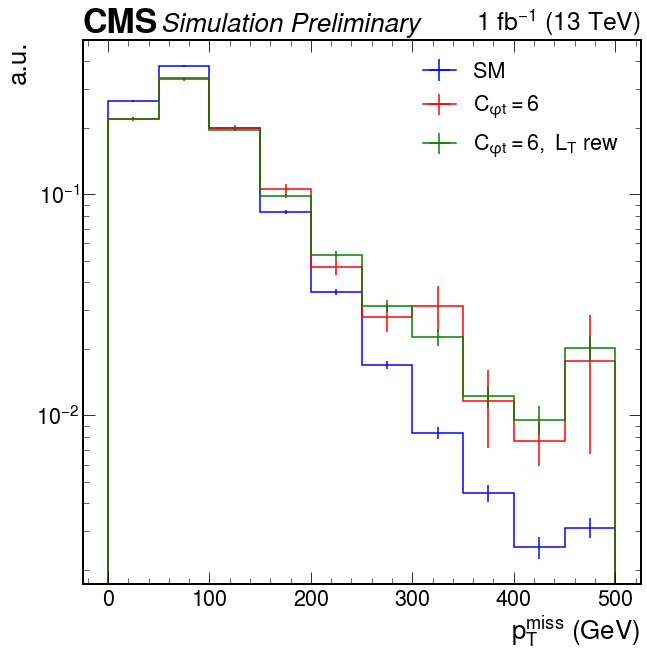

In [28]:
get_plot(ev.GenMET.pt, "10,0,500", axis_label=r'$p_{T}^{miss}\ (GeV)$', save='met_pt.pdf')

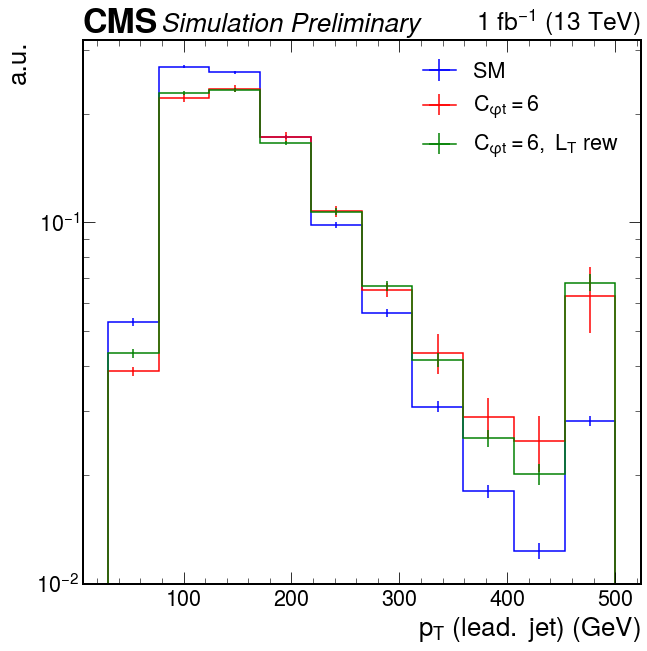

In [30]:
get_plot(
    ak.max(jet.pt, axis=1),
    "10,30,500",
    axis_label=r'$p_{T}\ (lead.\ jet)\ (GeV)$',
    save='leading_jet_pt.pdf'
)

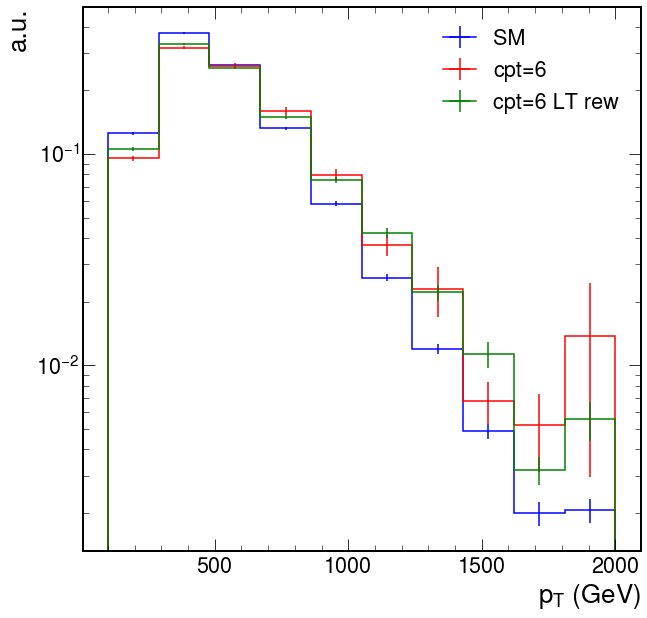

In [19]:
get_plot(
    ak.sum(jet.pt, axis=1),
    "10,100,2000",
)

/home/users/dspitzba/miniconda3/envs/coffeadev4/lib/python3.9/site-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


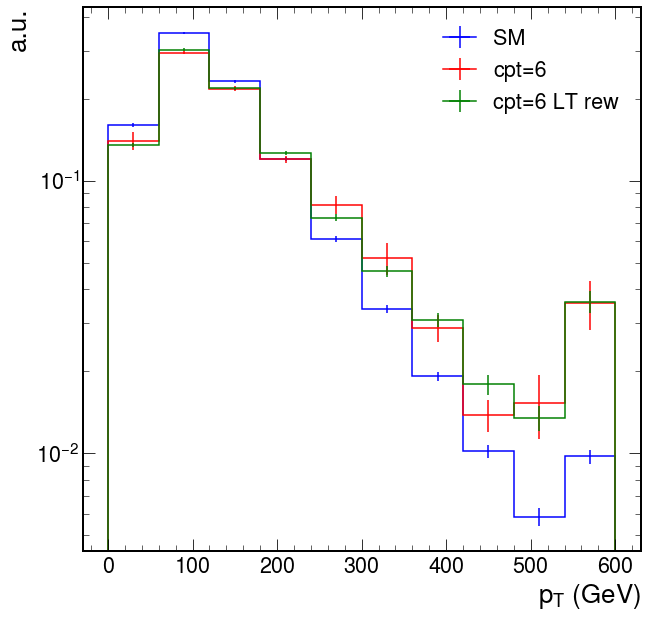

In [20]:
get_plot(
    (lep[:,0] + lep[:,1]).mass,
    "10,0,600",
)

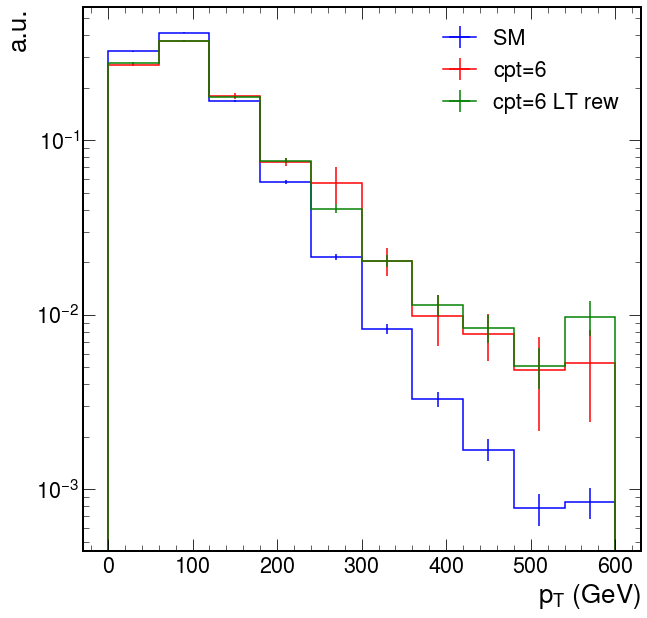

In [21]:
get_plot(
    (lep[:,0] + lep[:,1]).pt,
    "10,0,600",
)

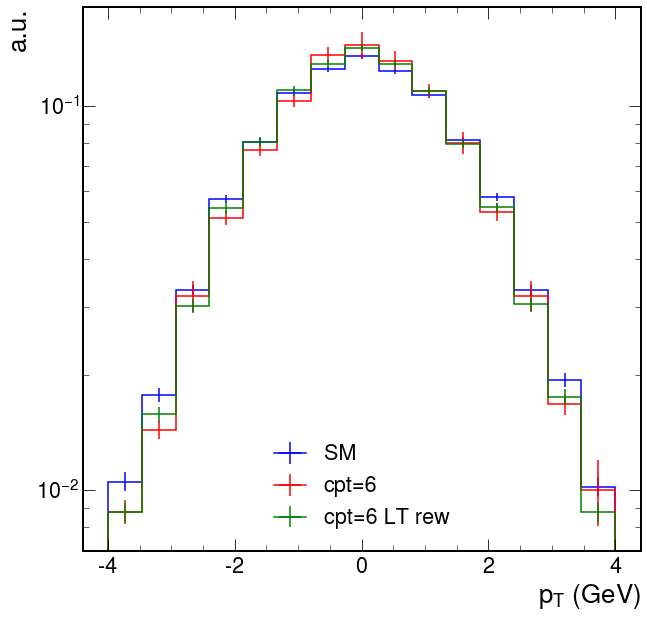

In [22]:
get_plot(
    lep[:,0].eta - lep[:,1].eta,
    "15,-4,4",
)

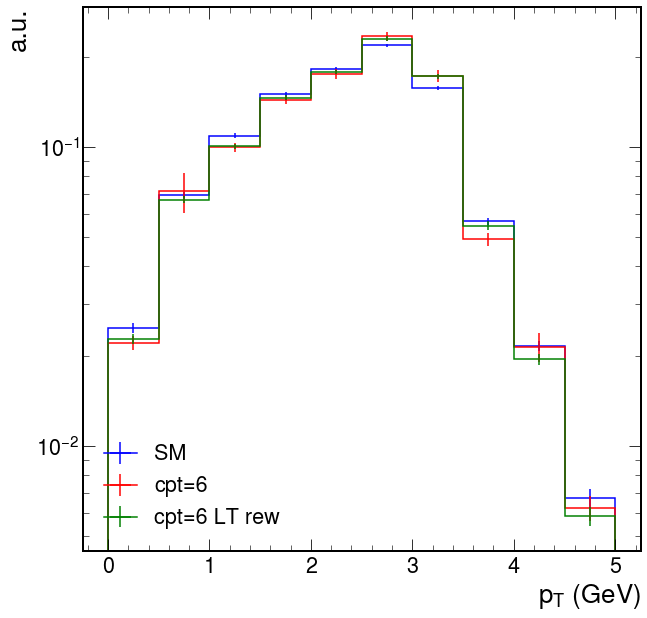

In [23]:
get_plot(
    lep[:,0].delta_r(lep[:,1]),
    "10,0,5",
)

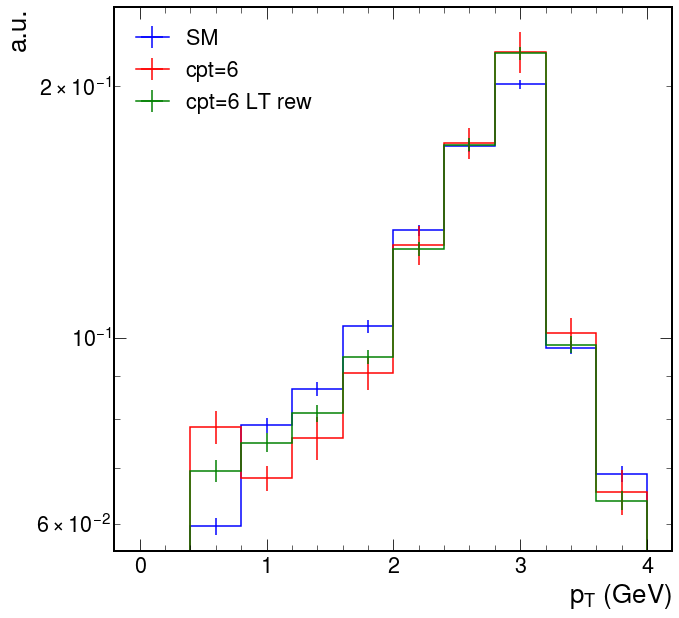

In [24]:
get_plot(
    lep[:,0].delta_r(jet[:,0]),
    "10,0,4",
)

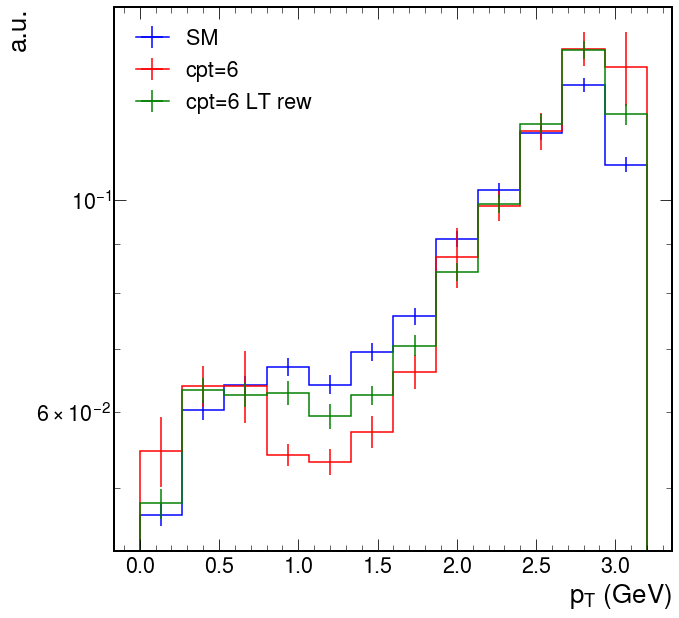

In [25]:
from Tools.objects import delta_phi_alt

get_plot(
    delta_phi_alt(lep[:,0], jet[:,0]),
    "12,0,3.2",
)

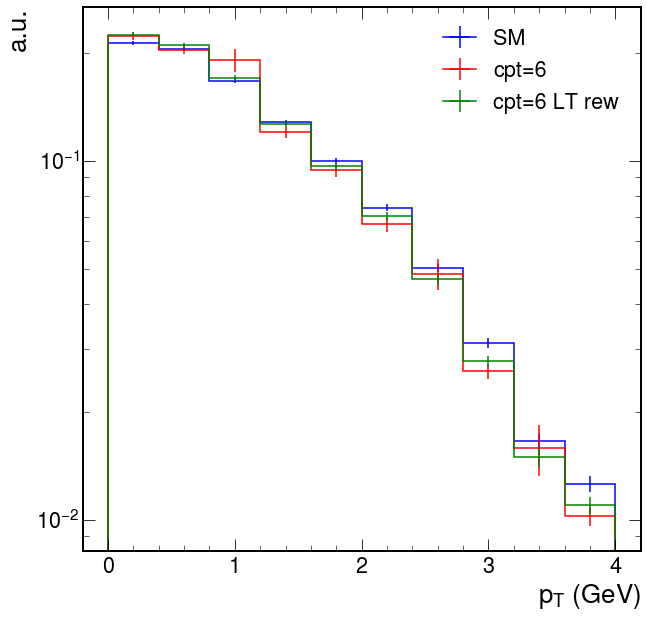

In [26]:
get_plot(
    abs(lep[:,0].eta-jet[:,0].eta),
    "10,0,4",
)

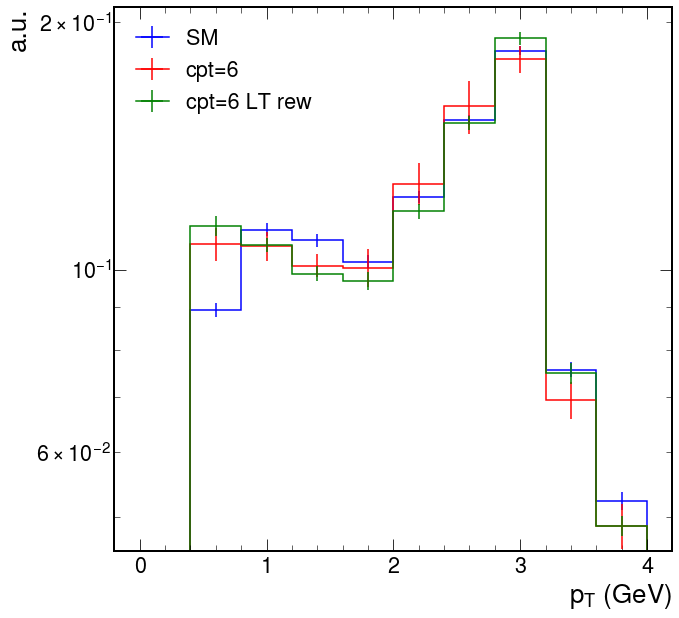

In [27]:
get_plot(
    lep[:,1].delta_r(jet[:,0]),
    "10,0,4",
)

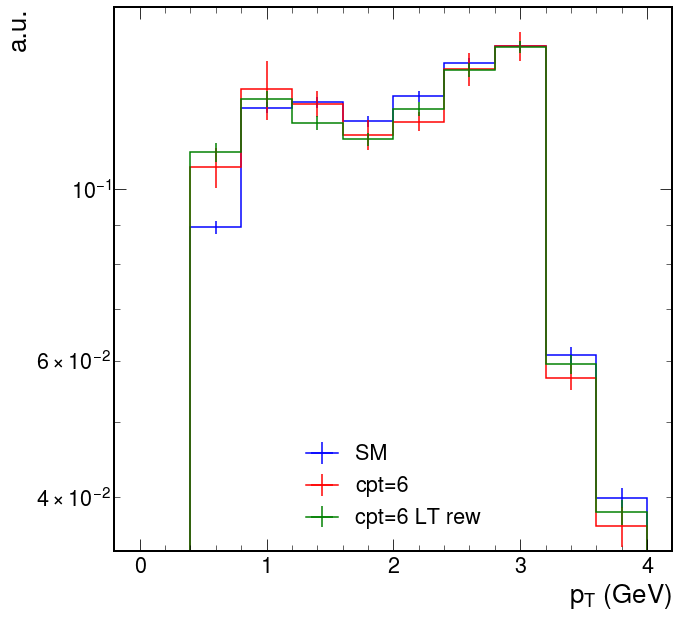

In [28]:
get_plot(
    lep[:,1].delta_r(jet[:,1]),
    "10,0,4",
)

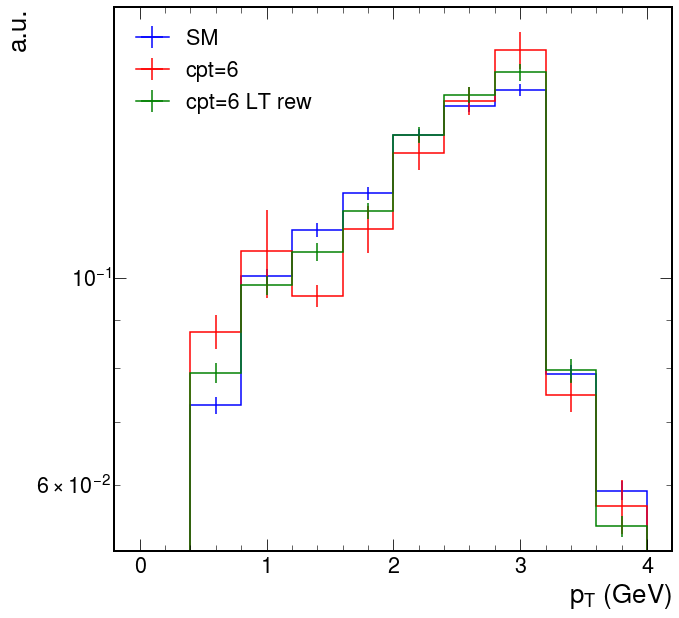

In [29]:
get_plot(
    lep[:,0].delta_r(jet[:,1]),
    "10,0,4",
)

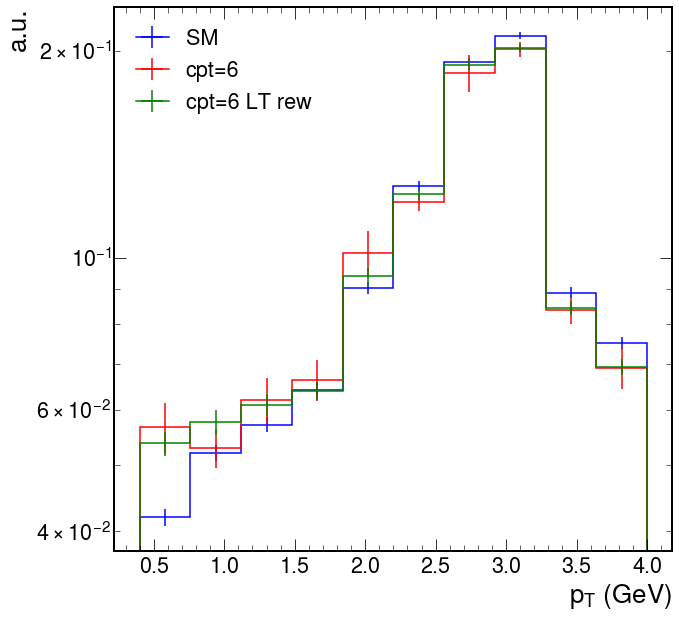

In [30]:
get_plot(
    jet[:,0].delta_r(jet[:,1]),
    "10,0.4,4",
)

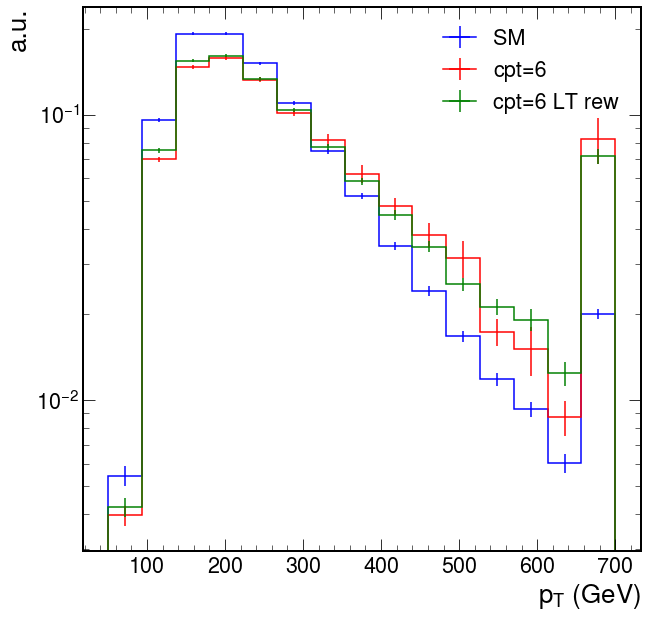

In [31]:
get_plot(
    lep[:,0].pt + jet[:,0].pt,
    "15,50,700",
)

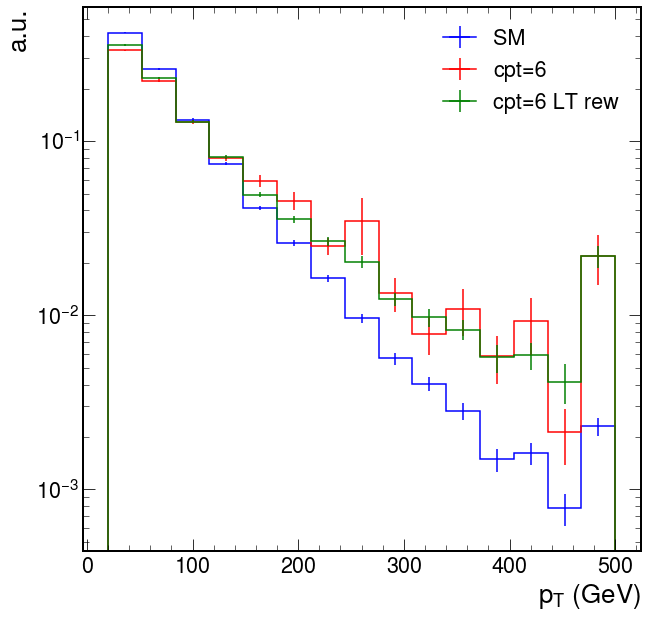

In [32]:
get_plot(
    lep[:,0].pt,
    "15,20,500",
)

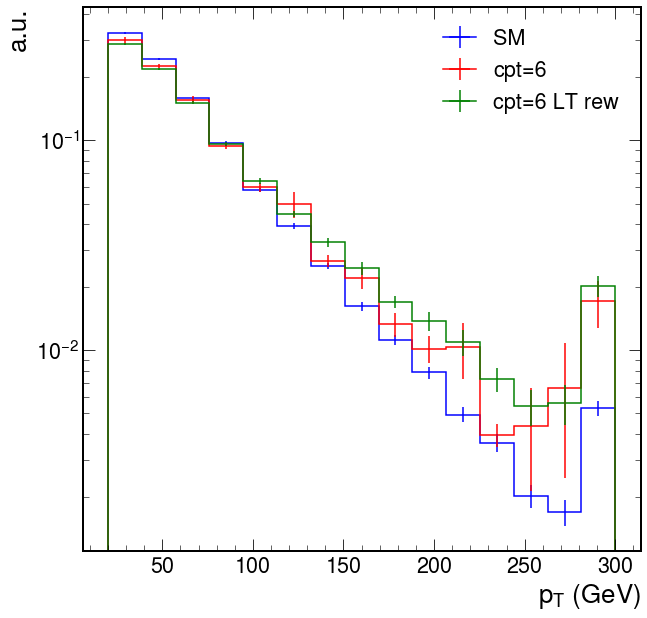

In [33]:
get_plot(
    lep[:,1].pt,
    "15,20,300",
)

In [ ]:
## accessing the four vectors does really take a lot of memory